In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm.notebook import tqdm
import ast  # for litteral_eval

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
# from sklearn.utils import resample
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
# from sklearn.ensemble import BaggingRegressor
# from sklearn.neural_network import MLPRegressor, MLPClassifier
# from xgboost import XGBClassifier, XGBRegressor

from utils import settings
from utils.file_mgmt import get_file_names, open_files, save_files
from utils.visualization import units, visualize_features
from utils.feature_analysis import test_stationarity, remove_non_stationary_features, seasonal_decomposition, remove_seasonality, vif_analysis, shift_features

import warnings
warnings.filterwarnings('ignore')

In [2]:
# sns.set()

# initialize the list of all settings to be used in this file
settings.init()

SEED = 450

## Data preparation

In [19]:
data = pd.read_csv("Data/dataset_monthly.csv", sep=';')
data_pct_change = pd.read_csv("Data/dataset_monthly_pct_change.csv", sep=';')
data['Date'] = pd.to_datetime(data['Date'])
data_pct_change['Date'] = pd.to_datetime(data_pct_change['Date'])

settings.add('ORIGINAL_COLS', data.columns)  # names of raw features
settings.add('UNITS', units)  # units are in utils.visualization
data = pd.merge(data, data_pct_change, on='Date')
data = data.iloc[:869]

In [21]:
# handle political orientation categories: D = 1, R = 0
pol_columns = ['potus', 'houseOfRep', 'fedChair']
for col in pol_columns:
    data[col] = data[col] == 'D'

# create X and Y sets
Y_COL = ['Fed_rate_month_avg', 'Fed_rate_spot_EOM',
         'Fed_rate_month_avg_diff', 'Fed_rate_month_avg_pct_change',
         'Fed_rate_month_avg_diff_3_class', 'Fed_rate_month_avg_diff_5_class',
         'Fed_rate_month_avg_diff_9_class', 'Fed_rate_month_avg_trend'
        ]
X_non_cols = ['Fed_rate_month_avg', 'Fed_rate_spot_EOM',
         'Fed_rate_month_avg_diff_3_class', 'Fed_rate_month_avg_diff_5_class',
         'Fed_rate_month_avg_diff_9_class', 'Fed_rate_month_avg_trend'
        ]
X, Y = data.drop(columns=X_non_cols), data[Y_COL + ['Date']]

In [22]:
# Create two settings for non numeric features and numeric features
settings.add('NON_NUM_COLS', ['Date', 'Recession', 'potus', 'houseOfRep', 'fedChair'])  # non numeric features (boolean, date, etc)
settings.add('NUM_COLS', [x for x in X.columns if x not in settings.get('NON_NUM_COLS')])  # numeric features

# Exclude features without seasonality correction already implemented
settings.add('EXCL_COLS', [c for c in X.columns if c.lower().replace('_pct_change', '')[-5:] == 'unadj'])

# Remaining features for next steps in X (useful only for experiments)
settings.add('KEPT_COLS', list(X.columns))
# settings.remove_columns_names('KEPT_COLS', ['Date'])
settings.remove_columns_names('KEPT_COLS',settings.get('EXCL_COLS'))

X = X[settings.get('KEPT_COLS')]
# X.describe(include='all')
# for feature in X.columns:
#     print(X[['Date', feature]].dropna().head(1))
#     print("\n")

## Data visualization

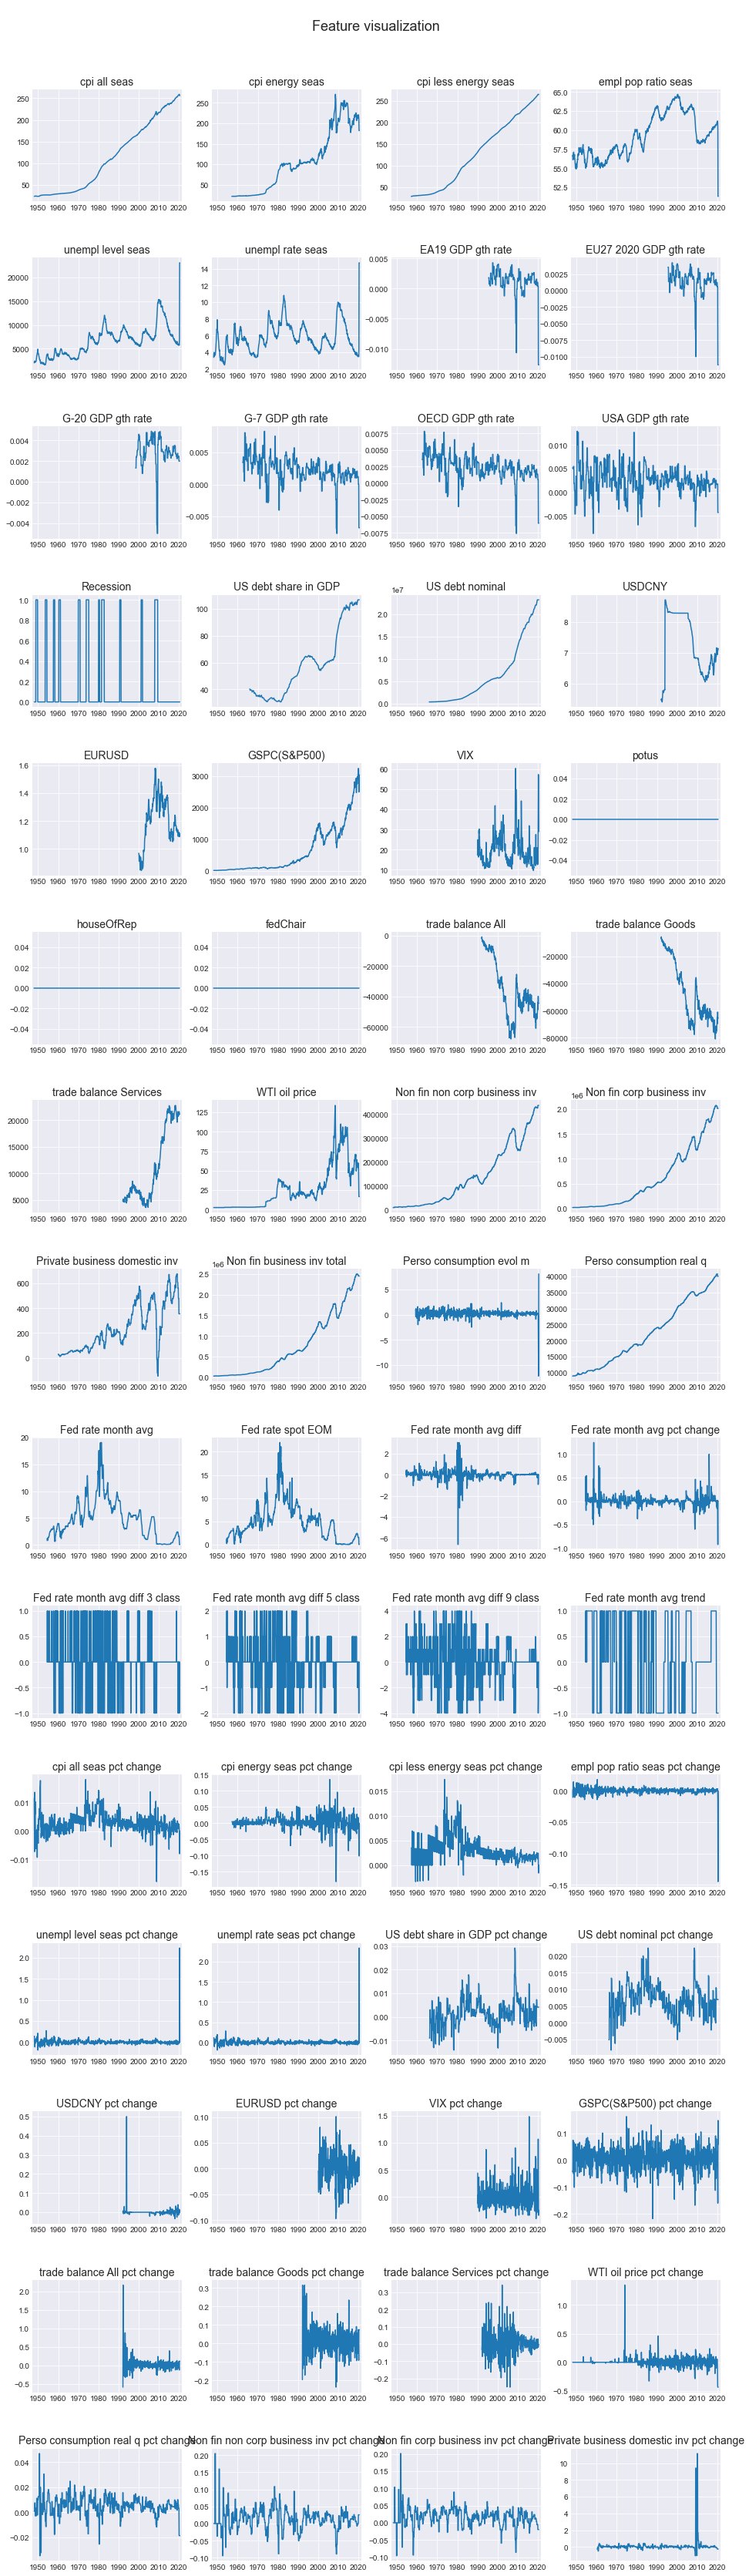

In [23]:
visualize_features(data=data,
                   excl_cols = settings.get('EXCL_COLS'),
                   date_col='Date',
                   ncols=4,
                   height_per_ax=3
                  )

## Feature selection

### 1. Feature stationarity

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/a

#### Dickey-Fuller test to ensure stationarity of variables

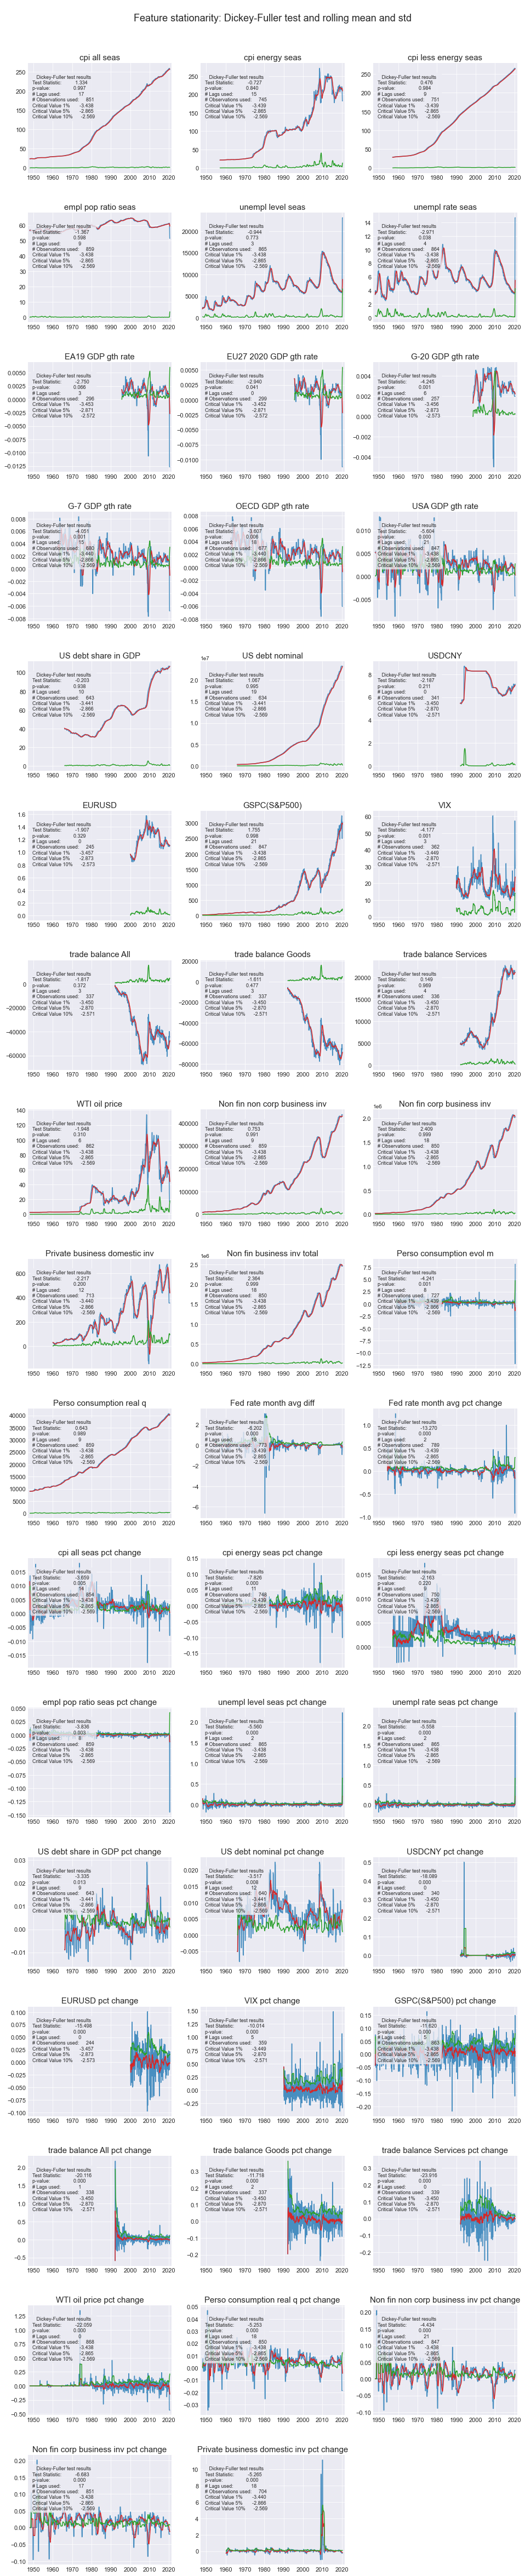

In [24]:
stat_results = test_stationarity(data,
                                columns=settings.get('NUM_COLS'),
                                excl_cols=settings.get('EXCL_COLS'),
                                date_col='Date',
                                stat_conf_level='5%',
                                plot_graphs=True,
                                plot_test_results=True
                               )

#### Take only stationary features, keep only one of original feature and "_pct_change"

In [25]:
kept_cols, dropped_cols = remove_non_stationary_features(X, stat_results)
settings.update('EXCL_COLS', settings.get('EXCL_COLS') + dropped_cols)
settings.update('KEPT_COLS',kept_cols)
X.describe()


------------------------------------- Non-stationarity: following features dropped -------------------------------------
cpi_all_seas
cpi_energy_seas
cpi_less_energy_seas
empl_pop_ratio_seas
unempl_level_seas
unempl_rate_seas_pct_change
EA19_GDP_gth_rate
US_debt_share_in_GDP
US_debt_nominal
USDCNY
EURUSD
GSPC(S&P500)
VIX_pct_change
trade_balance_All
trade_balance_Goods
trade_balance_Services
WTI_oil_price
Non_fin_non_corp_business_inv
Non_fin_corp_business_inv
Private_business_domestic_inv
Non_fin_business_inv_total
Perso_consumption_real_q


cpi_all_seas_pct_change  cpi_energy_seas_pct_change  \
count               869.000000                  760.000000   
mean                  0.002761                    0.003048   
std                   0.003338                    0.020851   
min                  -0.017705                   -0.180245   
25%                   0.000989                   -0.004171   
50%                   0.002415                    0.003157   
75%                   0.004252                    0.009675   
max                   0.018100                    0.134605   

       cpi_less_energy_seas_pct_change  empl_pop_ratio_seas_pct_change  \
count                       760.000000                      868.000000   
mean                          0.002946                       -0.000093   
std                           0.002515                        0.006099   
min                          -0.003356                       -0.145000   
25%                           0.001485                       -0.001706   
50%                           0.002439                        0.000000   
75%                           0.003646                        0.001721   
max                           0.017429                        0.018051   

       unempl_level_seas_pct_change  unempl_rate_seas  EU27_2020_GDP_gth_rate  \
count                    868.000000        869.000000              300.000000   
mean                       0.004760          5.747871                0.001293   
std                        0.085128          1.700111                0.002231   
min                       -0.187144          2.500000               -0.011226   
25%                       -0.019184          4.500000                0.000833   
50%                       -0.000393          5.500000                0.001680   
75%                        0.019335          6.800000                0.002339   
max                        2.232213         14.700000                0.004199   

       G-20_GDP_gth_rate  G-7_GDP_gth_rate  OECD_GDP_gth_rate  ...  \
count         264.000000        696.000000         696.000000  ...   
mean            0.002925          0.002282           0.002444  ...   
std             0.001508          0.002141           0.001979  ...   
min            -0.004994         -0.007653          -0.007575  ...   
25%             0.002454          0.001270           0.001476  ...   
50%             0.002929          0.002079           0.002388  ...   
75%             0.003766          0.003492           0.003563  ...   
max             0.004875          0.008321           0.007837  ...   

       trade_balance_Goods_pct_change  trade_balance_Services_pct_change  \
count                      340.000000                         340.000000   
mean                         0.009458                           0.006484   
std                          0.070373                           0.066659   
min                         -0.235778                          -0.250081   
25%                         -0.030411                          -0.017715   
50%                          0.007932                           0.006942   
75%                          0.050265                           0.029271   
max                          0.316025                           0.341811   

       WTI_oil_price_pct_change  Non_fin_non_corp_business_inv_pct_change  \
count                869.000000                                869.000000   
mean                   0.003977                                  0.014271   
std                    0.082877                                  0.033270   
min                   -0.433413                                 -0.093944   
25%                   -0.001348                                 -0.000305   
50%                    0.000000                                  0.015310   
75%                    0.020026                                  0.031957   
max                    1.345708                                  0.204685   

       Non_fin_corp_business_inv_pct_chan

### 2. Feature seasonality

Date
1948-01-31    0.011534
1948-02-29   -0.000422
1948-03-31   -0.007182
1948-04-30    0.013617
1948-05-31    0.007976
Name: cpi_all_seas_pct_change, dtype: float64
Date
1957-02-28    0.004695
1957-03-31    0.004673
1957-04-30    0.004651
1957-05-31    0.000000
1957-06-30    0.000000
Name: cpi_energy_seas_pct_change, dtype: float64
Date
1957-02-28    0.003521
1957-03-31    0.003509
1957-04-30    0.000000
1957-05-31    0.003497
1957-06-30    0.003484
Name: cpi_less_energy_seas_pct_change, dtype: float64
Date
1948-02-29    0.001767
1948-03-31   -0.010582
1948-04-30    0.010695
1948-05-31   -0.008818
1948-06-30    0.014235
Name: empl_pop_ratio_seas_pct_change, dtype: float64
Date
1948-02-29    0.144543
1948-03-31    0.030498
1948-04-30   -0.005419
1948-05-31   -0.112322
1948-06-30    0.045326
Name: unempl_level_seas_pct_change, dtype: float64
Date
1948-01-31    3.4
1948-02-29    3.8
1948-03-31    4.0
1948-04-30    3.9
1948-05-31    3.5
Name: unempl_rate_seas, dtype: float64
Date
1995-06-

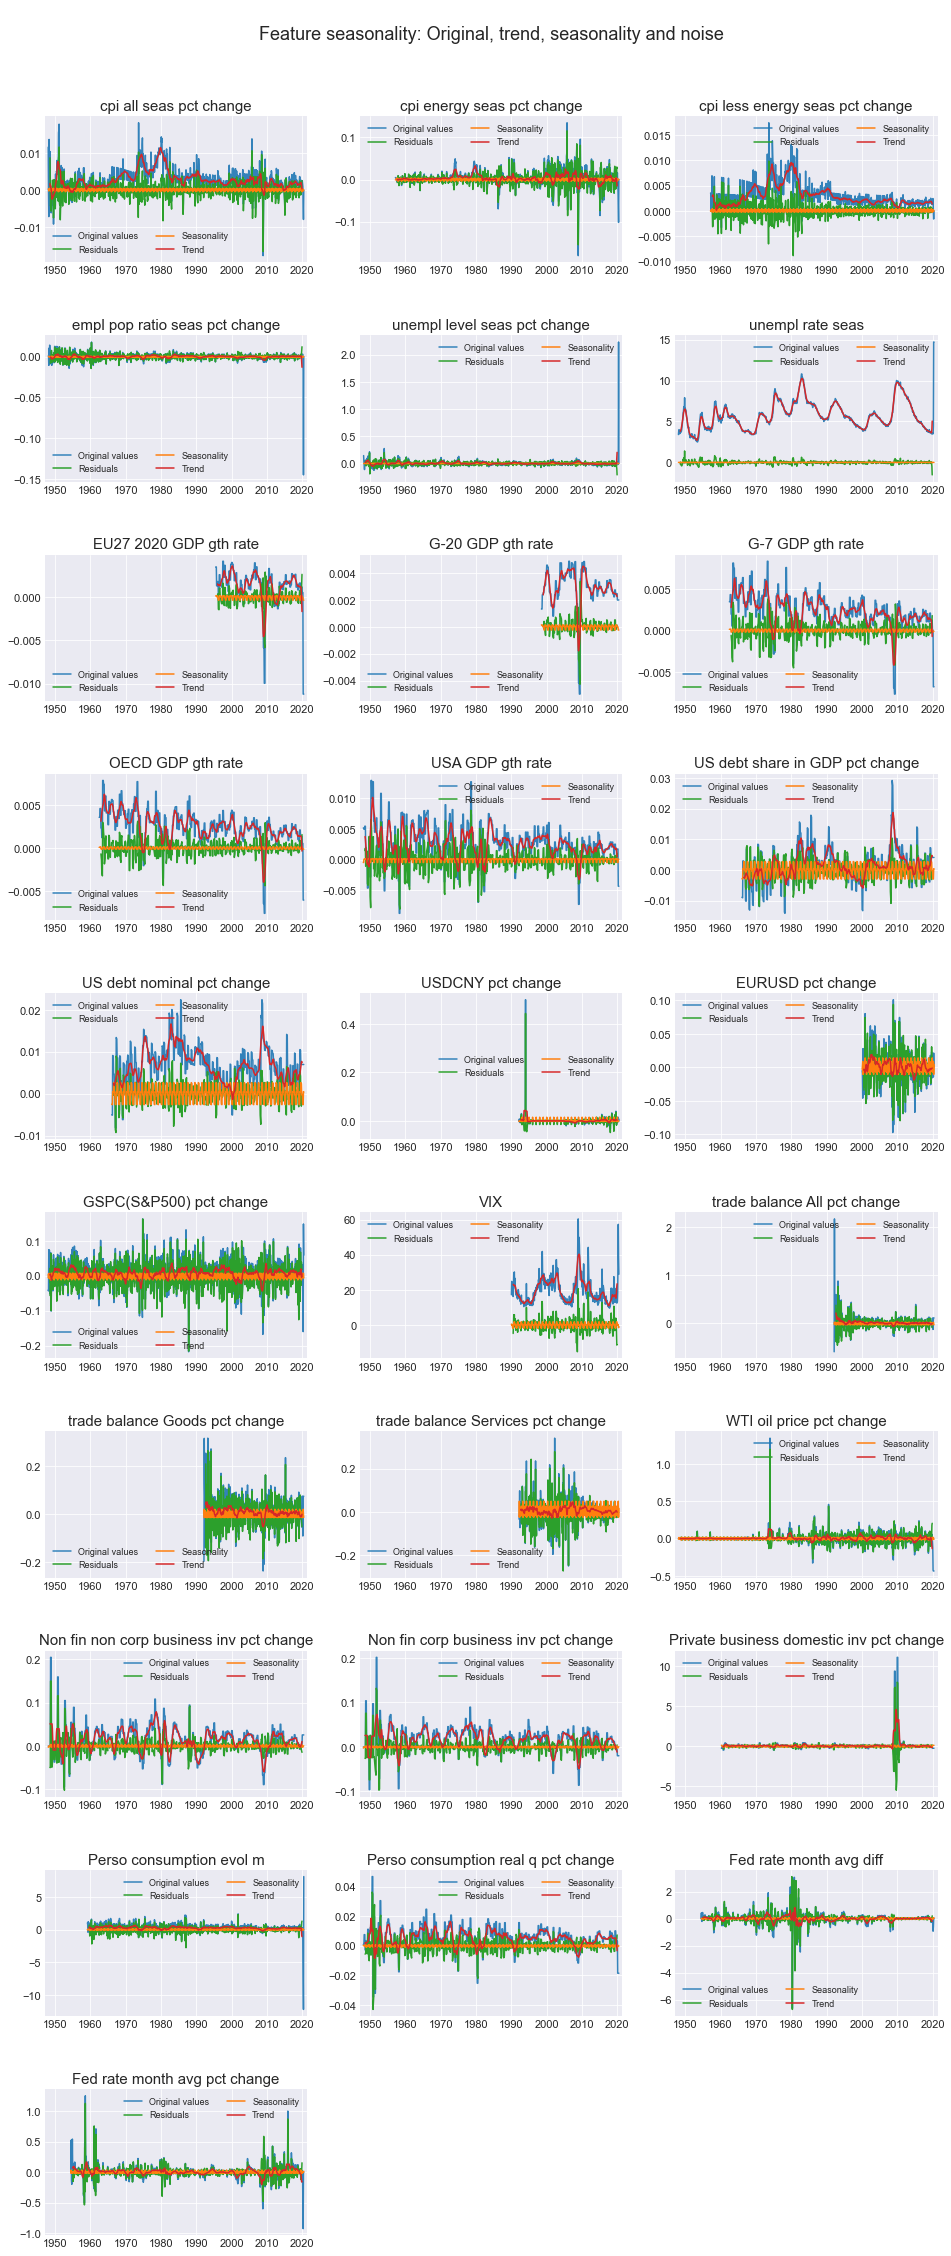

In [26]:
X_trend, X_seas, X_resid = seasonal_decomposition(X,
                                                 date_col='Date',
                                                 excl_cols=settings.get('NON_NUM_COLS'),
                                                 plot_graphs=True,
                                                 height_per_ax=3,
                                                 ncols=3
                                                )

In [27]:
_ = remove_seasonality(X, X_seas, threshold = 0.15)        

----------------------------------- Seasonality removed from the following features ------------------------------------
cpi_energy_seas_pct_change
cpi_less_energy_seas_pct_change
US_debt_share_in_GDP_pct_change
US_debt_nominal_pct_change
USDCNY_pct_change
EURUSD_pct_change
GSPC(S&P500)_pct_change
VIX
trade_balance_Goods_pct_change
trade_balance_Services_pct_change
WTI_oil_price_pct_change
Perso_consumption_evol_m
Fed_rate_month_avg_pct_change
------------------------------ Following features not found in provided data or data_seas ------------------------------
Recession
potus
houseOfRep
fedChair


Date
1948-01-31    0.011534
1948-02-29   -0.000422
1948-03-31   -0.007182
1948-04-30    0.013617
1948-05-31    0.007976
Name: cpi_all_seas_pct_change, dtype: float64
Date
1957-02-28    0.005240
1957-03-31    0.004967
1957-04-30    0.003759
1957-05-31    0.000030
1957-06-30   -0.003164
Name: cpi_energy_seas_pct_change, dtype: float64
Date
1957-02-28    0.003553
1957-03-31    0.003308
1957-04-30    0.000064
1957-05-31    0.003560
1957-06-30    0.003620
Name: cpi_less_energy_seas_pct_change, dtype: float64
Date
1948-02-29    0.001767
1948-03-31   -0.010582
1948-04-30    0.010695
1948-05-31   -0.008818
1948-06-30    0.014235
Name: empl_pop_ratio_seas_pct_change, dtype: float64
Date
1948-02-29    0.144543
1948-03-31    0.030498
1948-04-30   -0.005419
1948-05-31   -0.112322
1948-06-30    0.045326
Name: unempl_level_seas_pct_change, dtype: float64
Date
1948-01-31    3.4
1948-02-29    3.8
1948-03-31    4.0
1948-04-30    3.9
1948-05-31    3.5
Name: unempl_rate_seas, dtype: float64
Date
1995-06-

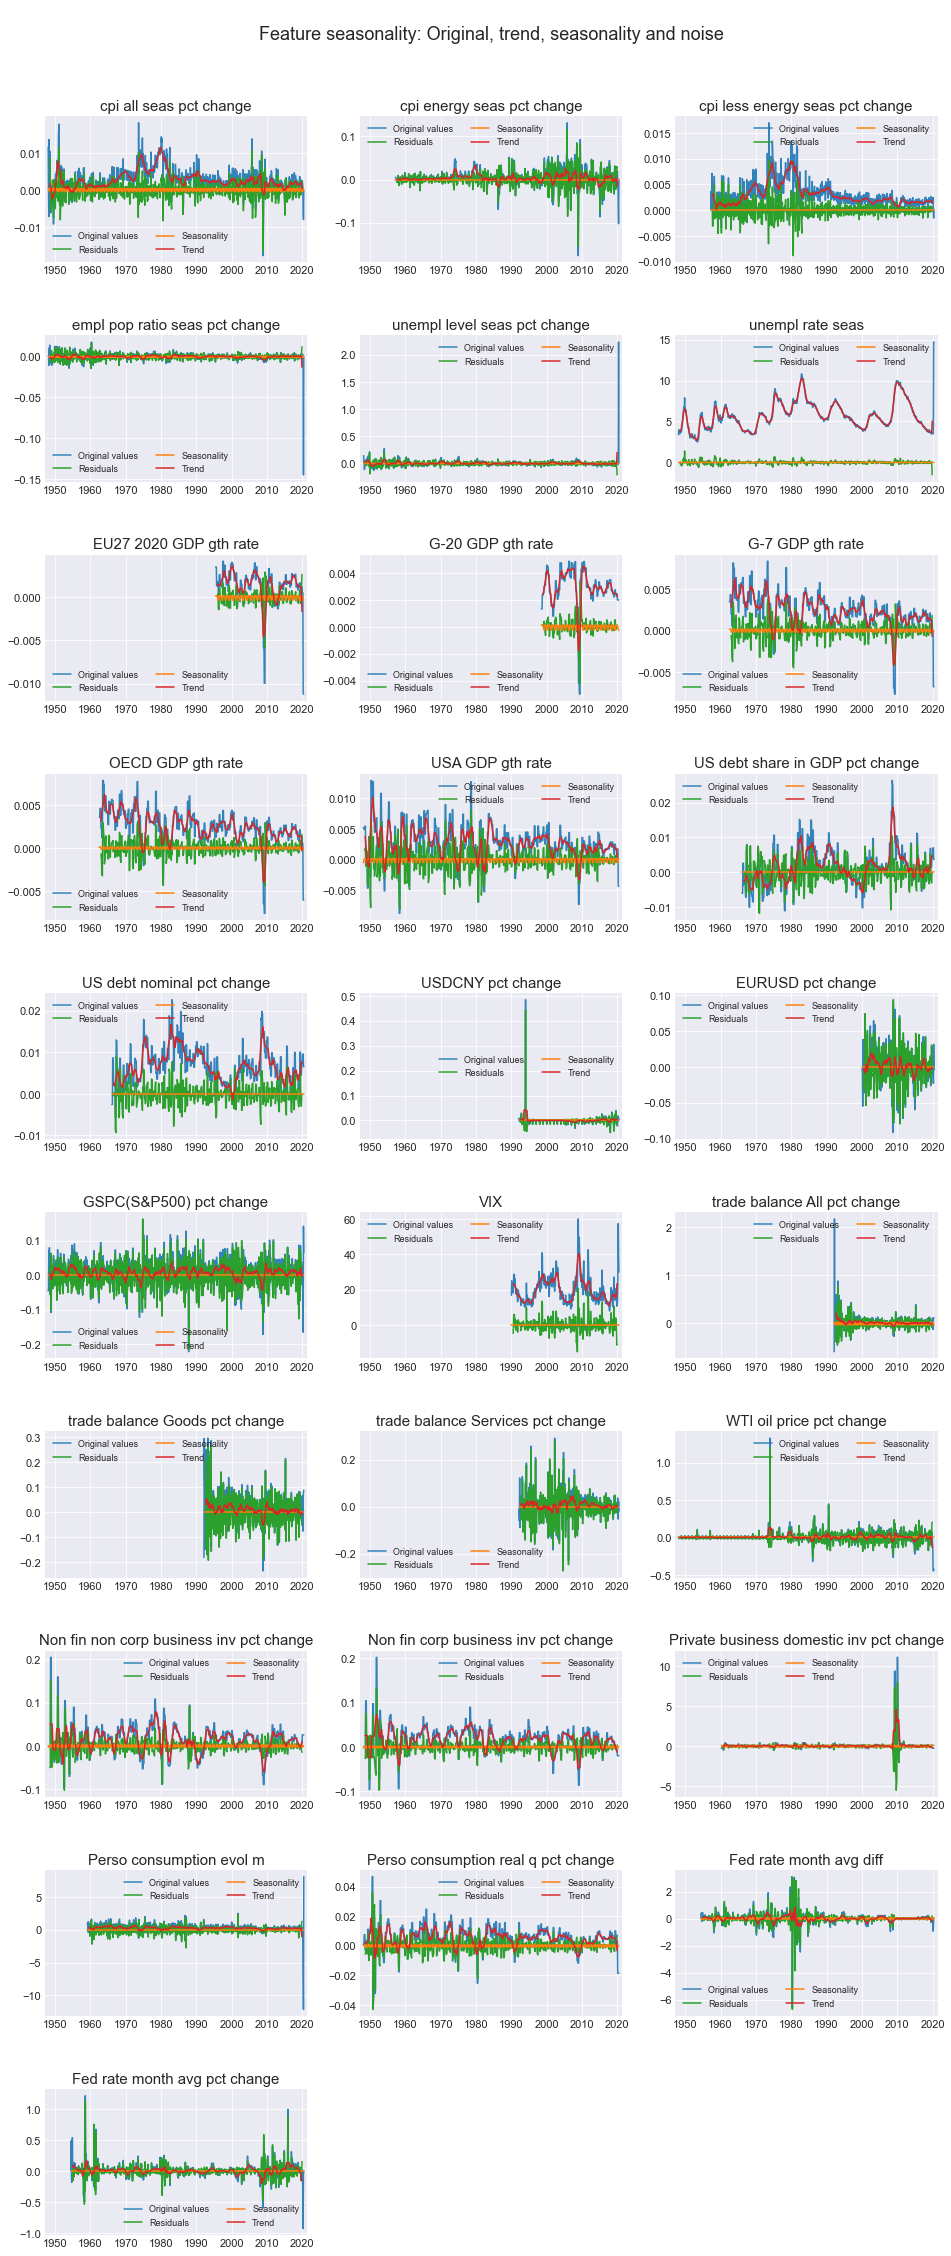

In [28]:
_, _, _ = seasonal_decomposition(X,
                                 date_col='Date',
                                 excl_cols=settings.get('NON_NUM_COLS'),
                                 plot_graphs=True,
                                 height_per_ax=3,
                                 ncols=3
                                )

Date
1954-06-30    0.80
1954-07-31    1.22
1954-08-31    1.06
1954-09-30    0.85
1954-10-31    0.83
Name: Fed_rate_month_avg, dtype: float64
Date
1954-06-30    1.13
1954-07-31    0.25
1954-08-31    1.44
1954-09-30    0.50
1954-10-31    1.38
Name: Fed_rate_spot_EOM, dtype: float64
Date
1954-06-30    0.00
1954-07-31    0.42
1954-08-31   -0.16
1954-09-30   -0.21
1954-10-31   -0.02
Name: Fed_rate_month_avg_diff, dtype: float64
Date
1954-06-30    0.000000
1954-07-31    0.525000
1954-08-31   -0.131148
1954-09-30   -0.198113
1954-10-31   -0.023529
Name: Fed_rate_month_avg_pct_change, dtype: float64
Date
1954-06-30    0.0
1954-07-31    1.0
1954-08-31    0.0
1954-09-30    0.0
1954-10-31    0.0
Name: Fed_rate_month_avg_diff_3_class, dtype: float64
Date
1954-06-30    0.0
1954-07-31    2.0
1954-08-31   -1.0
1954-09-30   -1.0
1954-10-31    0.0
Name: Fed_rate_month_avg_diff_5_class, dtype: float64
Date
1954-06-30    0.0
1954-07-31    3.0
1954-08-31   -1.0
1954-09-30   -1.0
1954-10-31    0.0
Name: Fe

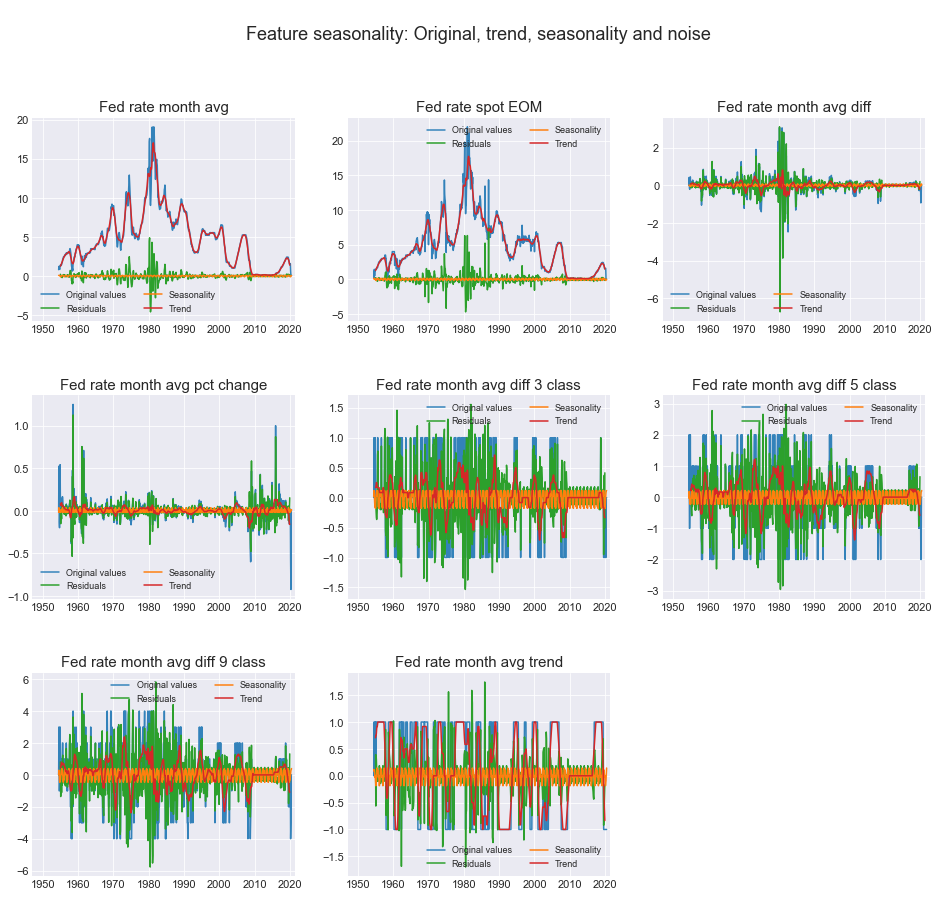

In [29]:
Y_trend, Y_seas, Y_resid = seasonal_decomposition(Y,
                                                 date_col='Date',
                                                 plot_graphs=True,
                                                 height_per_ax=4,
                                                 width_per_ax=6,                                                
                                                 ncols=3
                                                )

### 3. Feature normalization

In [30]:
scaled_cols = [x for x in settings.get('KEPT_COLS') if x in settings.get('NUM_COLS')]
X_scaled = preprocessing.StandardScaler().fit_transform(X[scaled_cols])
X[scaled_cols] = pd.DataFrame(X_scaled, columns=scaled_cols)

### 4. Add lagged features

In [31]:
settings.add('ROW_SHIFT', (1, 2, 3, 6, 12))
data_shifted = shift_features(X,
                              row_shifts = (1, 2, 3, 6, 12,)
#                               row_shifts=settings.get('ROW_SHIFT')
                             )
X = pd.concat([X, data_shifted], axis=1)  

In [73]:
# X[['EURUSD_pct_change', 'Date']].dropna()

In [32]:
X.drop(columns=list(set(x.split("_t-")[0] for x in X.columns) - set(['Date'])), inplace=True)

In [33]:
# Boolean features were converted to weird type, let's convert them back to booleans
X.loc[:, X.dtypes == 'O'] = X.loc[:, X.dtypes == 'O'].astype(bool)

### 5. Feature correlation

In [35]:
# set important dates for X and Y
# settings.add('START_DATE', dt.datetime(1960, 1, 1))
settings.add('START_DATE', dt.datetime(1992, 1, 1))
# settings.add('START_DATE', dt.datetime(2001, 2, 1))
settings.add('END_DATE', dt.datetime(2020, 5, 1))

#### Dropping features with NAN within start date and end date

In [36]:
# Only after START DATE
try:
    X = X.loc[(X['Date'] >= settings.get('START_DATE')) & (X['Date'] <= settings.get('END_DATE'))]
    Y = Y.iloc[X.index]
except IndexError:
    pass

# Removing features with NaN after STARTDATE
X = X.dropna(axis=1)

# Ensuring Y has values everywhere
# Y = Y.dropna()
# X = X.iloc[Y.index]

#### First correlation matrix

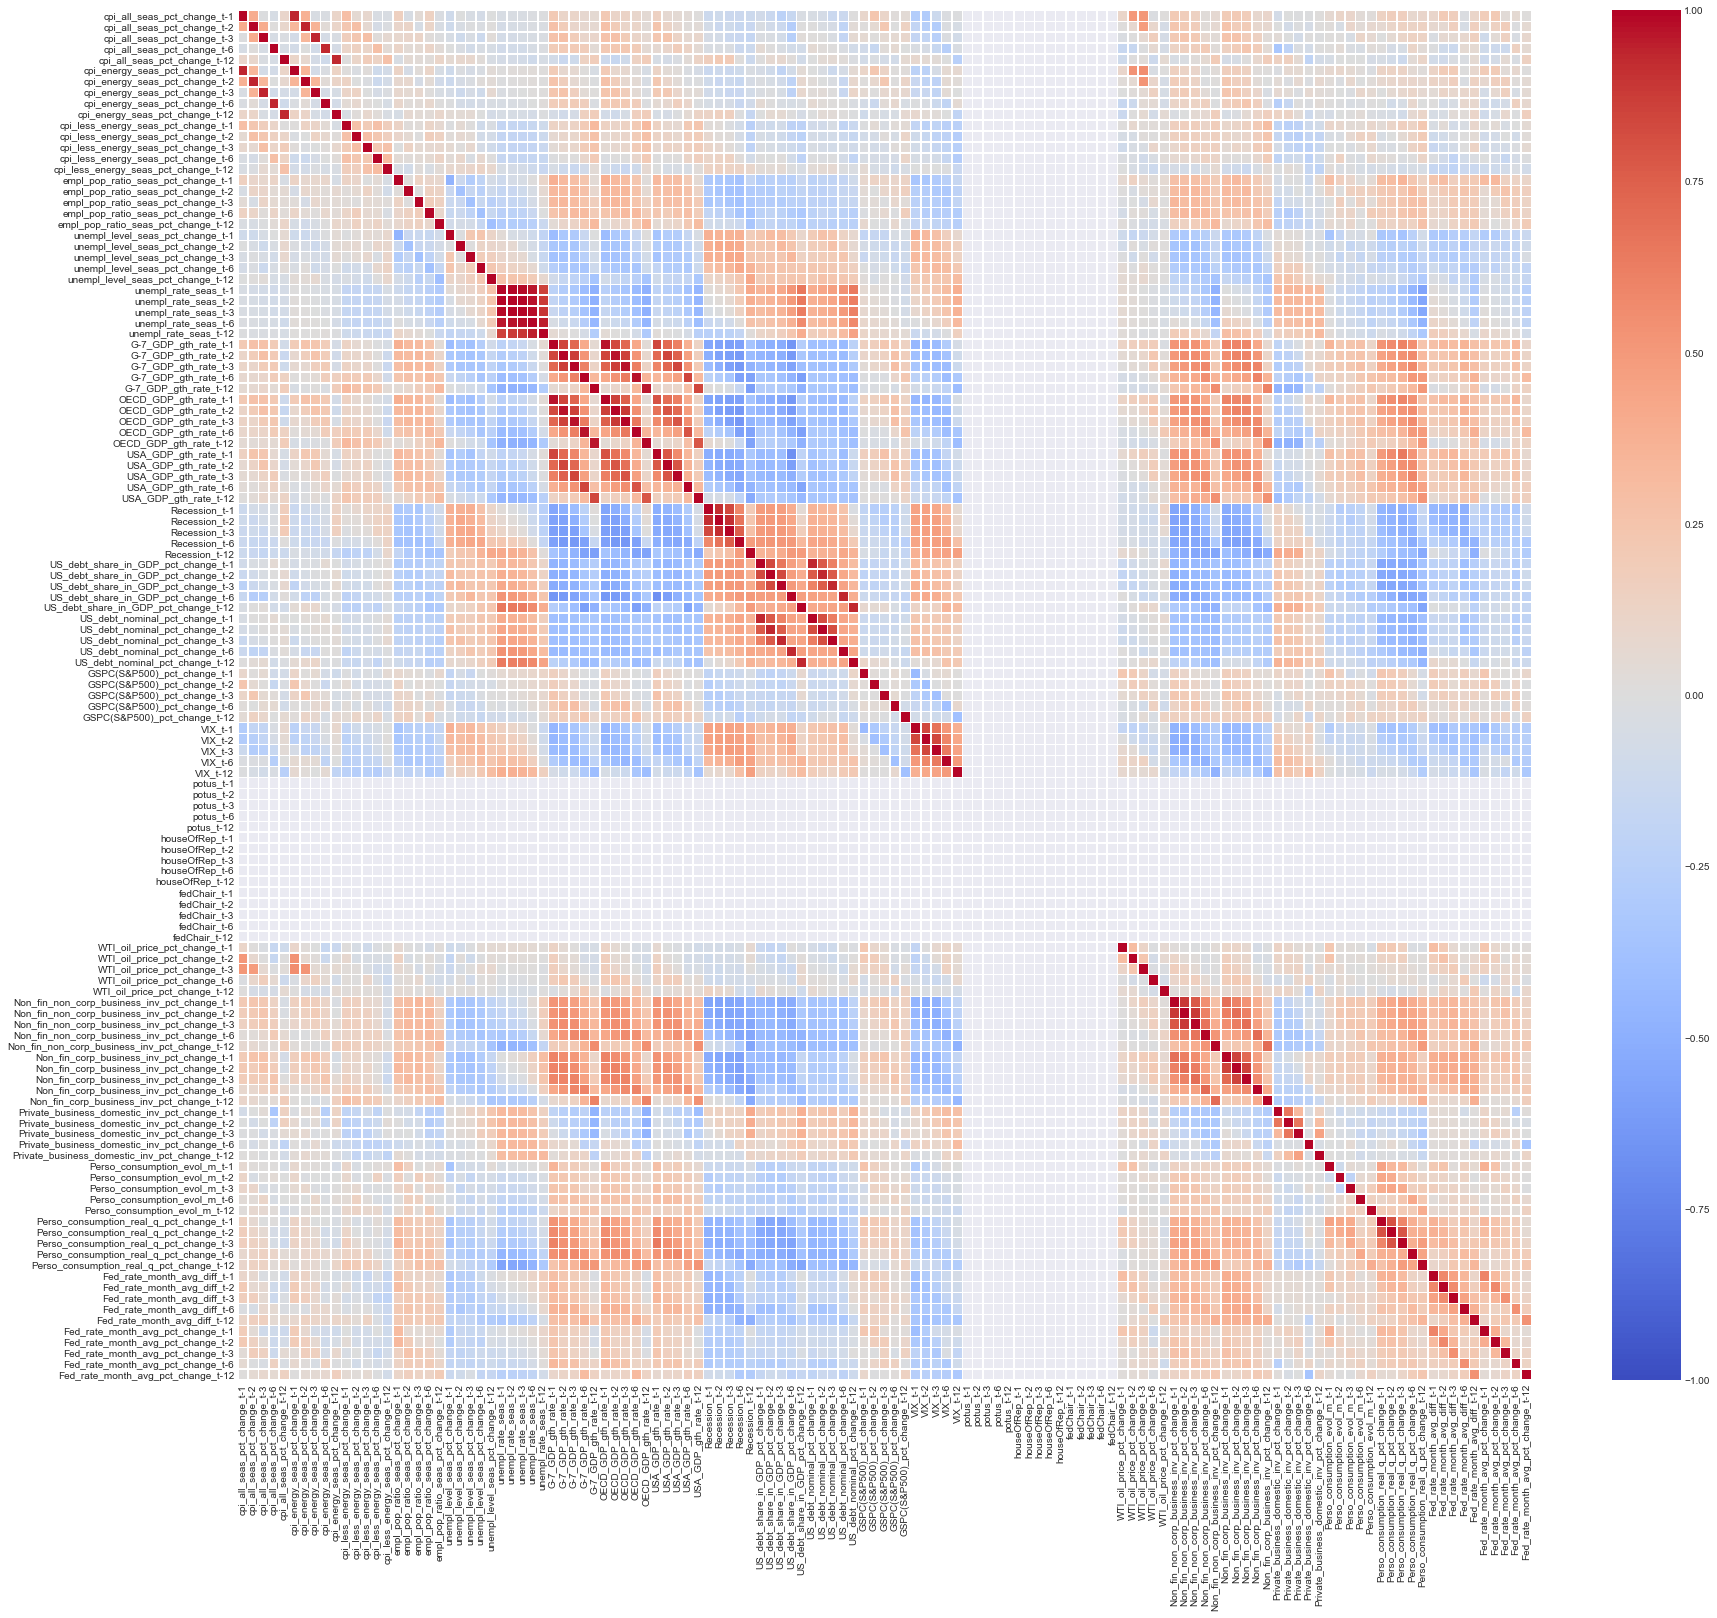

In [37]:
fig = plt.figure(figsize = (0.23 * len(X.columns), 0.2 * len(X.columns)))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

#### VIF analysis

In [39]:
# Compute features to be analysed by VIF
columns_vif = [x for x in X.columns if x.split("_t-")[0] in settings.get('NUM_COLS')]

In [40]:
vif, excl_columns_vif = vif_analysis(X, columns_vif, threshold=10)
vif.sort_values('VIF_factor', ascending=False).head()


----------------------------------------- VIF analysis starting: 105 features ------------------------------------------
------------------------------------------ VIF analysis succesfully completed ------------------------------------------
remaining features: 78
excluded features: 27


VIF_factor                                      features
49    9.714677      Non_fin_corp_business_inv_pct_change_t-2
50    7.754142      Non_fin_corp_business_inv_pct_change_t-3
48    7.106618      Non_fin_corp_business_inv_pct_change_t-1
45    7.088632  Non_fin_non_corp_business_inv_pct_change_t-3
35    6.888227                                       VIX_t-1

In [41]:
pd.DataFrame.from_dict(excl_columns_vif, orient='index', columns=['VIF value when excluded'])

VIF value when excluded
unempl_rate_seas_t-2                                      1934.408391
unempl_rate_seas_t-3                                      1402.770917
unempl_rate_seas_t-6                                       258.923391
OECD_GDP_gth_rate_t-2                                      184.654925
US_debt_share_in_GDP_pct_change_t-6                        102.977114
G-7_GDP_gth_rate_t-3                                        93.664652
G-7_GDP_gth_rate_t-1                                        88.626121
G-7_GDP_gth_rate_t-6                                        70.053946
G-7_GDP_gth_rate_t-12                                       62.007345
unempl_rate_seas_t-1                                        59.644034
US_debt_share_in_GDP_pct_change_t-2                         57.064711
cpi_all_seas_pct_change_t-3                                 41.590091
cpi_all_seas_pct_change_t-6                                 39.480517
cpi_all_seas_pct_change_t-2                                 38.686492
cpi_all_seas_pct_change_t-1                                 38.166148
cpi_all_seas_pct_change_t-12                                37.691450
G-7_GDP_gth_rate_t-2                                        29.058863
US_debt_share_in_GDP_pct_change_t-3                         27.406478
US_debt_share_in_GDP_pct_change_t-12                        24.915610
OECD_GDP_gth_rate_t-3                                       20.765541
OECD_GDP_gth_rate_t-1                                       17.242100
Non_fin_non_corp_business_inv_pct_change_t-2                16.010695
US_debt_nominal_pct_change_t-1                              15.471738
VIX_t-2                                                     14.800615
OECD_GDP_gth_rate_t-6                                       14.593871
USA_GDP_gth_rate_t-2                                        14.209189
OECD_GDP_gth_rate_t-12                                      12.593293

In [42]:
for col_name in excl_columns_vif.keys():
    try:
        X.drop(columns=[col_name], inplace=True)
    except KeyError:
        print("Column {:s} have already been removed".format(col_name))

#### FInal correlation matrix

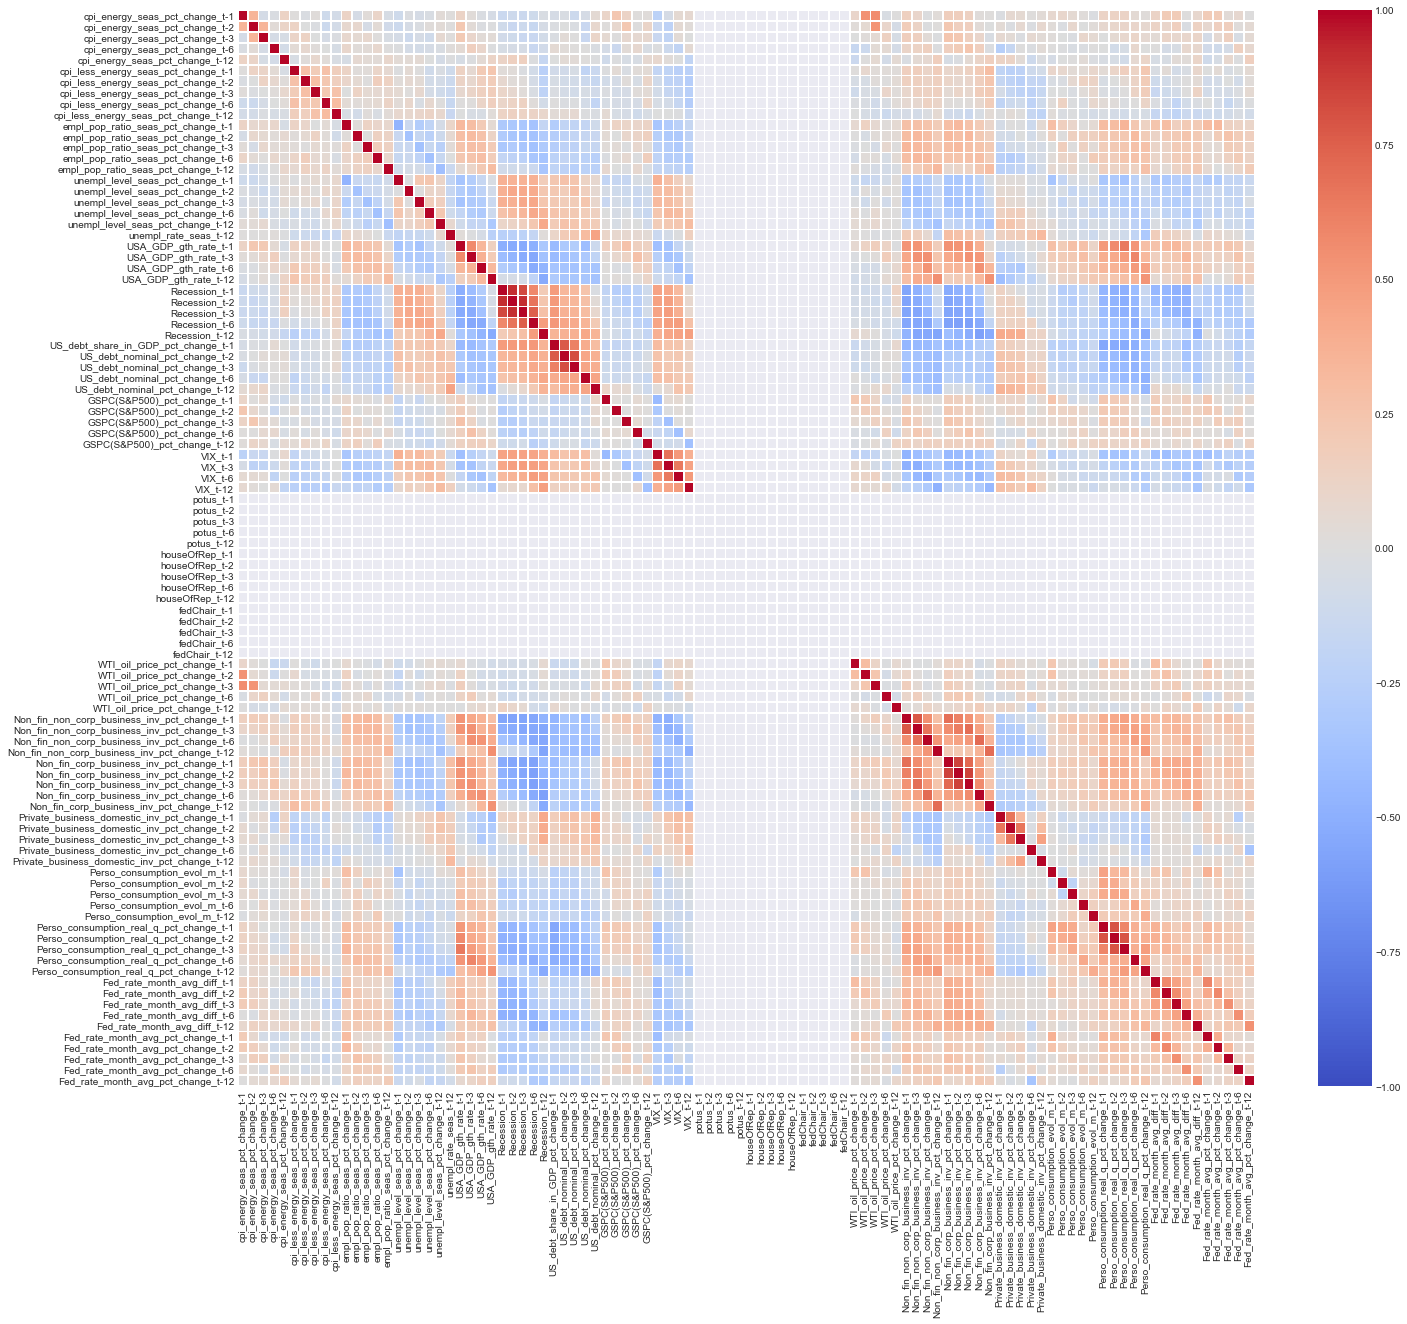

In [43]:
fig = plt.figure(figsize = (0.23 * len(X.columns), 0.2 * len(X.columns)))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

### 6. Train and Test split and save dataset

In [44]:
train_test_ratio = 0.7
test_date = settings.get('START_DATE') + train_test_ratio * (settings.get('END_DATE') - settings.get('START_DATE'))
settings.add('TEST_DATE', test_date)

X_train, X_test = X.loc[X['Date'] < settings.get('TEST_DATE')], X.loc[X['Date'] >= settings.get('TEST_DATE')]
Y_train, Y_test = Y.loc[Y['Date'] < settings.get('TEST_DATE')], Y.loc[Y['Date'] >= settings.get('TEST_DATE')]
X_train.drop(columns=['Date'], inplace=True)
X_test.drop(columns=['Date'], inplace=True)

In [45]:
files = [X_train, Y_train, X_test, Y_test]
file_names = ["X_train", "Y_train", "X_test", "Y_test"]
file_names = [f + "_t-" + "_".join([str(i) for i in settings.get('ROW_SHIFT')]) + ".csv" for f in file_names]
save_files(
    path='Models/startdate_{:s}_testdate_{:s}/'.format(settings.get('START_DATE').strftime("%Y"),
                                                       settings.get('TEST_DATE').strftime("%Y")
                                                      ),
    files=dict(zip(file_names, files)),
    replace=True
    )


------------------------- 4 file(s) saved succesfully in Models/startdate_1992_testdate_2011/ --------------------------


In [46]:
path = 'Models/startdate_{:s}_testdate_{:s}/'.format(settings.get('START_DATE').strftime("%Y"),
                                                       settings.get('TEST_DATE').strftime("%Y")
                                                      )
test = pd.read_csv(path + 'X_train_t-1_2_3_6_12.csv', sep=';')
with pd.option_context('max_columns', 200):
    print(test.head(20))

    cpi_energy_seas_pct_change_t-1  cpi_energy_seas_pct_change_t-2  \
0                         0.318791                        0.430519   
1                        -0.960065                        0.318791   
2                        -0.263418                       -0.960065   
3                        -0.132901                       -0.263418   
4                        -0.094764                       -0.132901   
5                         0.139893                       -0.094764   
6                         0.315295                        0.139893   
7                         0.075983                        0.315295   
8                        -0.342314                        0.075983   
9                        -0.265778                       -0.342314   
10                        0.294443                       -0.265778   
11                        0.420682                        0.294443   
12                        0.080728                        0.420682   
13                  